In [26]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Lambda, Dense, Activation, Flatten, GlobalAveragePooling2D 
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential 
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from glob import glob
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
train_path = '/kaggle/input/tomatoleaf/tomato/train'
valid_path = '/kaggle/input/tomatoleaf/tomato/val'

In [16]:
# knowing number of classes 
folders = glob('/kaggle/input/tomatoleaf/tomato/train/*')
len(folders)

10

In [21]:
#preprocessing Data for Inception Model
train_batches = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
).flow_from_directory(
    directory=train_path,
    target_size=(299, 299), 
    batch_size=10
)

valid_batches = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
).flow_from_directory(
    directory=valid_path,
    target_size=(299, 299),
    batch_size=10
)

Found 10000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [23]:
# Load the InceptionV3 model without the top layer and with pre-trained ImageNet weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))


In [24]:
base_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_188 (Conv2D) │ (None, 149, 149,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 149, 149,  │         96 │ conv2d_188[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_188      │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_189 (Conv2D) │ (None, 147, 147,  │      9,216 │ activation_188[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_189[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_189      │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_190 (Conv2D) │ (None, 147, 147,  │     18,432 │ activation_189[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_190[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_190      │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 73, 73,    │          0 │ activation_190[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_191 (Conv2D) │ (None, 73, 73,    │      5,120 │ max_pooling2d_8[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_191[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_191      │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_192 (Conv2D) │ (None, 71, 71,    │    138,240 │ activation_191[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_192[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_192      │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [27]:
# Add global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

In [28]:
#defining the Last layer
x = Dense(1024, activation='relu')(x)

In [29]:
predictions = Dense(10, activation='softmax')(x)

In [30]:
model = Model(inputs=base_model.input, outputs=predictions)

In [31]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_188 (Conv2D) │ (None, 149, 149,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 149, 149,  │         96 │ conv2d_188[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_188      │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_189 (Conv2D) │ (None, 147, 147,  │      9,216 │ activation_188[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_189[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_189      │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_190 (Conv2D) │ (None, 147, 147,  │     18,432 │ activation_189[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_190[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_190      │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 73, 73,    │          0 │ activation_190[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_191 (Conv2D) │ (None, 73, 73,    │      5,120 │ max_pooling2d_8[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_191[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_191      │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_192 (Conv2D) │ (None, 71, 71,    │    138,240 │ activation_191[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_192[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_192      │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 23,911,210 (91.21 MB)

 Trainable params: 23,876,778 (91.08 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [33]:
#function to plot images in the form of grid with 1 row 10 columns from traiing data

def plotImages(images_arr):
  fig, axes = plt.subplots(1, 10, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip( images_arr, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()



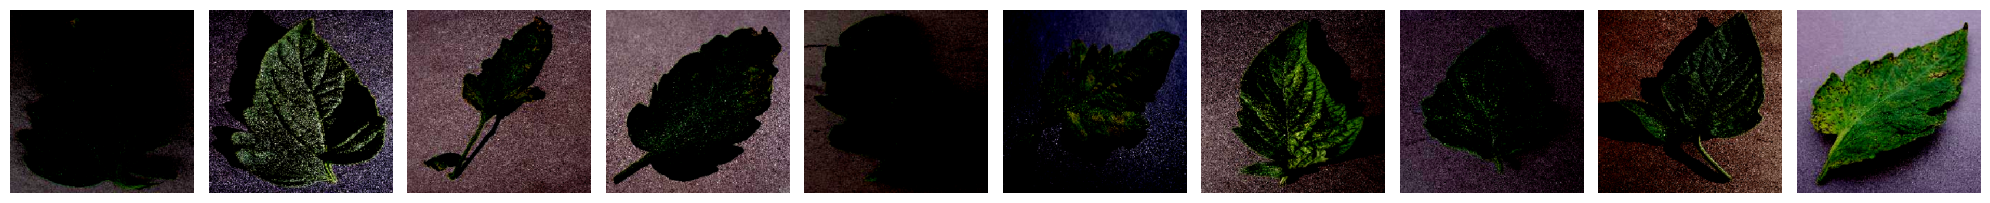

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [34]:
imgs, labels = next(train_batches)
plotImages(imgs)
print(labels)

In [35]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
model.fit(x= train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1722379576.023016     624 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1722379576.124896     624 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722379679.569259     626 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1000/1000 - 189s - 189ms/step - accuracy: 0.6871 - loss: 0.9200 - val_accuracy: 0.6360 - val_loss: 1.3829
Epoch 2/10
1000/1000 - 101s - 101ms/step - accuracy: 0.8562 - loss: 0.4361 - val_accuracy: 0.8370 - val_loss: 0.5778
Epoch 3/10
1000/1000 - 101s - 101ms/step - accuracy: 0.8885 - loss: 0.3246 - val_accuracy: 0.8480 - val_loss: 0.5059
Epoch 4/10
1000/1000 - 101s - 101ms/step - accuracy: 0.9118 - loss: 0.2642 - val_accuracy: 0.3110 - val_loss: 5.4928
Epoch 5/10
1000/1000 - 101s - 101ms/step - accuracy: 0.9242 - loss: 0.2265 - val_accuracy: 0.8270 - val_loss: 0.6188
Epoch 6/10
1000/1000 - 101s - 101ms/step - accuracy: 0.9313 - loss: 0.2013 - val_accuracy: 0.8940 - val_loss: 0.2902
Epoch 7/10
1000/1000 - 101s - 101ms/step - accuracy: 0.9389 - loss: 0.1756 - val_accuracy: 0.8060 - val_loss: 0.7937
Epoch 8/10
1000/1000 - 102s - 102ms/step - accuracy: 0.9466 - loss: 0.1618 - val_accuracy: 0.8740 - val_loss: 0.4217
Epoch 9/10
1000/1000 - 101s - 101ms/step - accuracy: 0.9526 - loss: 0.1471 

In [36]:
class_labels = train_batches.class_indices

#Class Labels and their Integer Values
for label, value in class_labels.items():
    print(f"{label}: {value}")

Tomato___Bacterial_spot: 0
Tomato___Early_blight: 1
Tomato___Late_blight: 2
Tomato___Leaf_Mold: 3
Tomato___Septoria_leaf_spot: 4
Tomato___Spider_mites Two-spotted_spider_mite: 5
Tomato___Target_Spot: 6
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 7
Tomato___Tomato_mosaic_virus: 8
Tomato___healthy: 9


In [40]:
predictions = model.predict(x=valid_batches, verbose=0)

W0000 00:00:1722380786.174351     624 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


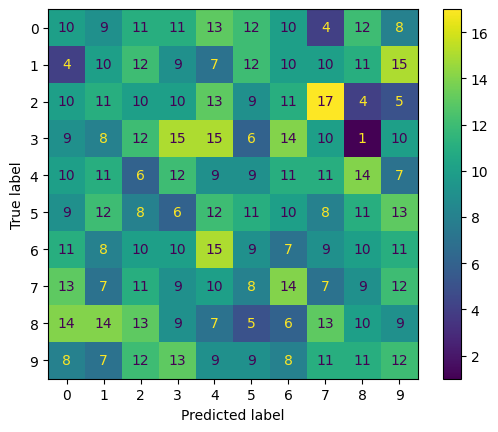

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_predictions(y_true=valid_batches.classes, y_pred=np.argmax(predictions, axis=-1))

# **Vgg16 model**

In [43]:
train_batches = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
                 .flow_from_directory(directory=train_path, target_size=(224,224), batch_size=10)

valid_batches = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
                 .flow_from_directory(directory=valid_path, target_size=(224,224), batch_size=10)

Found 10000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [44]:
vgg16_model = VGG16(weights='imagenet')

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


In [45]:
model =  tf.keras.models.Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [46]:
for layers  in model.layers:
    layers.trainable = False

In [52]:
model.add(tf.keras.layers.Dense(10, activation='softmax'))

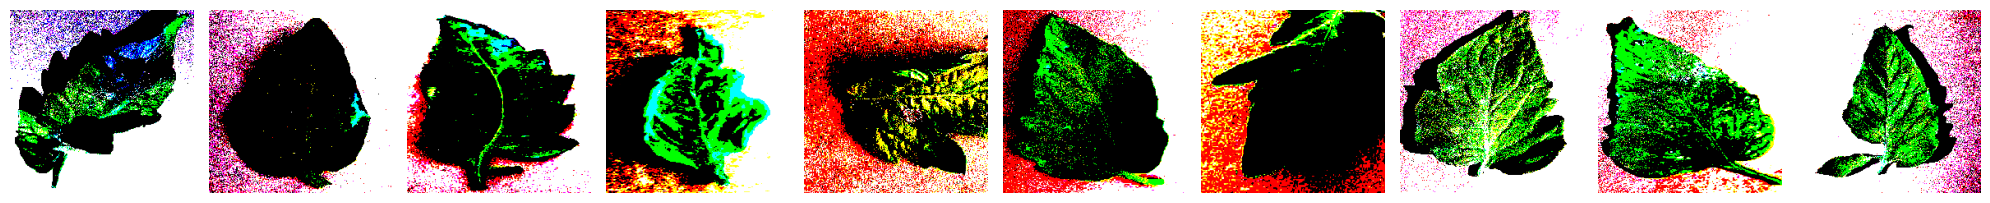

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


In [53]:
imgs, labels = next(valid_batches)
plotImages(imgs)
print(labels)

In [54]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [55]:
model.fit(x= train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-07-30 23:29:11.070408: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.17844, expected 3.56217
2024-07-30 23:29:11.070479: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.52289, expected 2.90662
2024-07-30 23:29:11.070494: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 4.66917, expected 4.05289
2024-07-30 23:29:11.070510: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 4.67338, expected 4.0571
2024-07-30 23:29:11.070544: E external/local_xla/xla/service/gpu/buffer_comparator.cc:

1000/1000 - 40s - 40ms/step - accuracy: 0.1259 - loss: 2.3098 - val_accuracy: 0.1270 - val_loss: 2.3048
Epoch 2/10
1000/1000 - 31s - 31ms/step - accuracy: 0.1002 - loss: 2.3041 - val_accuracy: 0.1000 - val_loss: 2.3030
Epoch 3/10
1000/1000 - 31s - 31ms/step - accuracy: 0.0971 - loss: 2.3033 - val_accuracy: 0.1260 - val_loss: 2.3021
Epoch 4/10
1000/1000 - 31s - 31ms/step - accuracy: 0.1039 - loss: 2.3031 - val_accuracy: 0.0900 - val_loss: 2.3038
Epoch 5/10
1000/1000 - 31s - 31ms/step - accuracy: 0.0994 - loss: 2.3037 - val_accuracy: 0.1000 - val_loss: 2.3024
Epoch 6/10
1000/1000 - 31s - 31ms/step - accuracy: 0.1053 - loss: 2.3027 - val_accuracy: 0.1180 - val_loss: 2.3012
Epoch 7/10
1000/1000 - 31s - 31ms/step - accuracy: 0.0971 - loss: 2.3011 - val_accuracy: 0.1060 - val_loss: 2.2982
Epoch 8/10
1000/1000 - 31s - 31ms/step - accuracy: 0.1125 - loss: 2.3030 - val_accuracy: 0.1000 - val_loss: 2.3048
Epoch 9/10
1000/1000 - 31s - 31ms/step - accuracy: 0.0963 - loss: 2.3046 - val_accuracy: 0.

In [56]:
predictions = model.predict(x=valid_batches, verbose=0)

W0000 00:00:1722382467.640295     623 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


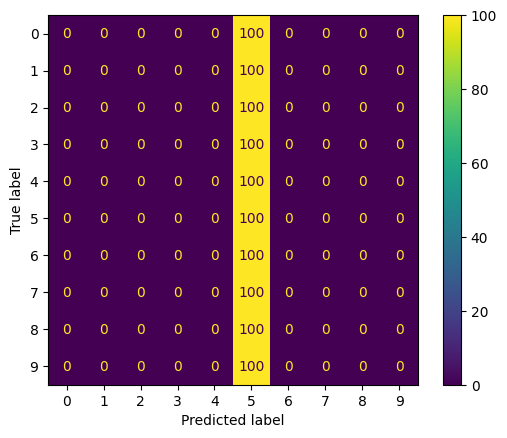

In [58]:
disp = ConfusionMatrixDisplay.from_predictions(y_true=valid_batches.classes, y_pred=np.argmax(predictions, axis=-1))
